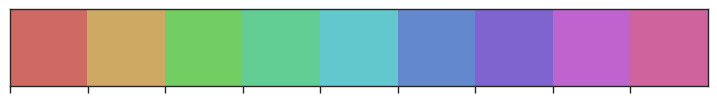

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal
from tqdm import tqdm


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


In [2]:

@numba.njit
def x_dot_init(x, y, V, params):
    dxdt = params[0]*V - (params[1] + params[3]) * x + params[2]/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot_init(x, y, V, params):
    dydt = params[1]*x - params[2]/(V**2) * x**2 * y
    return dydt
    
@numba.njit
def x_mark(V, params):
    return params[0]*V / params[3]

@numba.njit
def y_mark(V, params):
    return V * params[1] * params[3] / (params[2] * params[0])


In [3]:
# Euler method

@numba.njit
def euler(var_change, V, dt, t_max, params):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot_init(x, y, V, params)
        y += dt * y_dot_init(x, y, V, params)
        t += dt
    return x_list, y_list, t_list


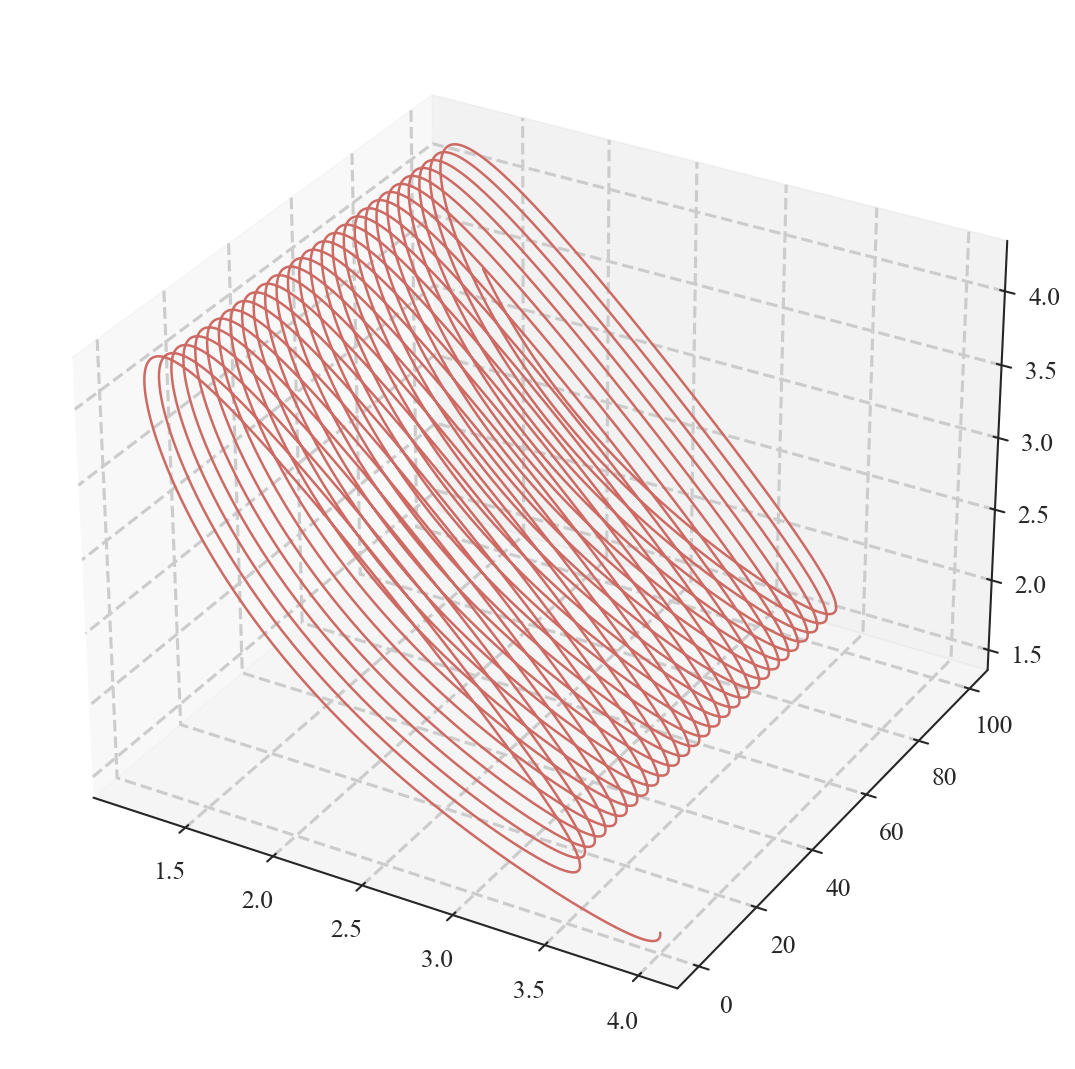

In [4]:

V = 1
var_change = np.array([4, 1.5])
dt = 0.01
t_max = 100
a = 2; b=5.5; c=1; d=1
params = np.array([a, b, c, d])

x_list, y_list, t_list = euler(var_change, V, dt, t_max, params)
x_star = x_mark(V, params)
y_star = y_mark(V, params)

# 3D plot
fig = plt.figure(figsize=(16,9), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, t_list, y_list)


In [5]:
# Finding peaks and mean freq of x(t) and y(t)

def freq_find(list1, list2):
    coord_peaks = []
    t_peaks = []
    for i in range(len(list1)-1):
        if list1[i] > list1[i-1] and list1[i] > list1[i+1]:
            coord_peaks.append(list1[i])
            t_peaks.append(list2[i])

    freq = []
    for j in range(len(t_peaks)-1):
        freq.append(1/(t_peaks[j+1] - t_peaks[j]))
    
    freq_mean = np.mean(freq)
    
    return freq_mean

# find the frequency of the peaks with homemade function
y_mean_freq = freq_find(y_list, t_list)

# Using fourier transformation np.fft
y_norm = y_list - np.mean(y_list)
fourier_y = np.fft.fft(y_norm)
freq = np.fft.fftfreq(len(y_list), d=0.1)
peak_freq_y = np.argmax(abs(fourier_y))

print(f"Mean frequency of y(t) from own method is {y_mean_freq}")
print(f"Mean frequency of y(t) from fft is {freq[peak_freq_y]}")

Mean frequency of y(t) from own method is 0.2754529852431573
Mean frequency of y(t) from fft is 0.028


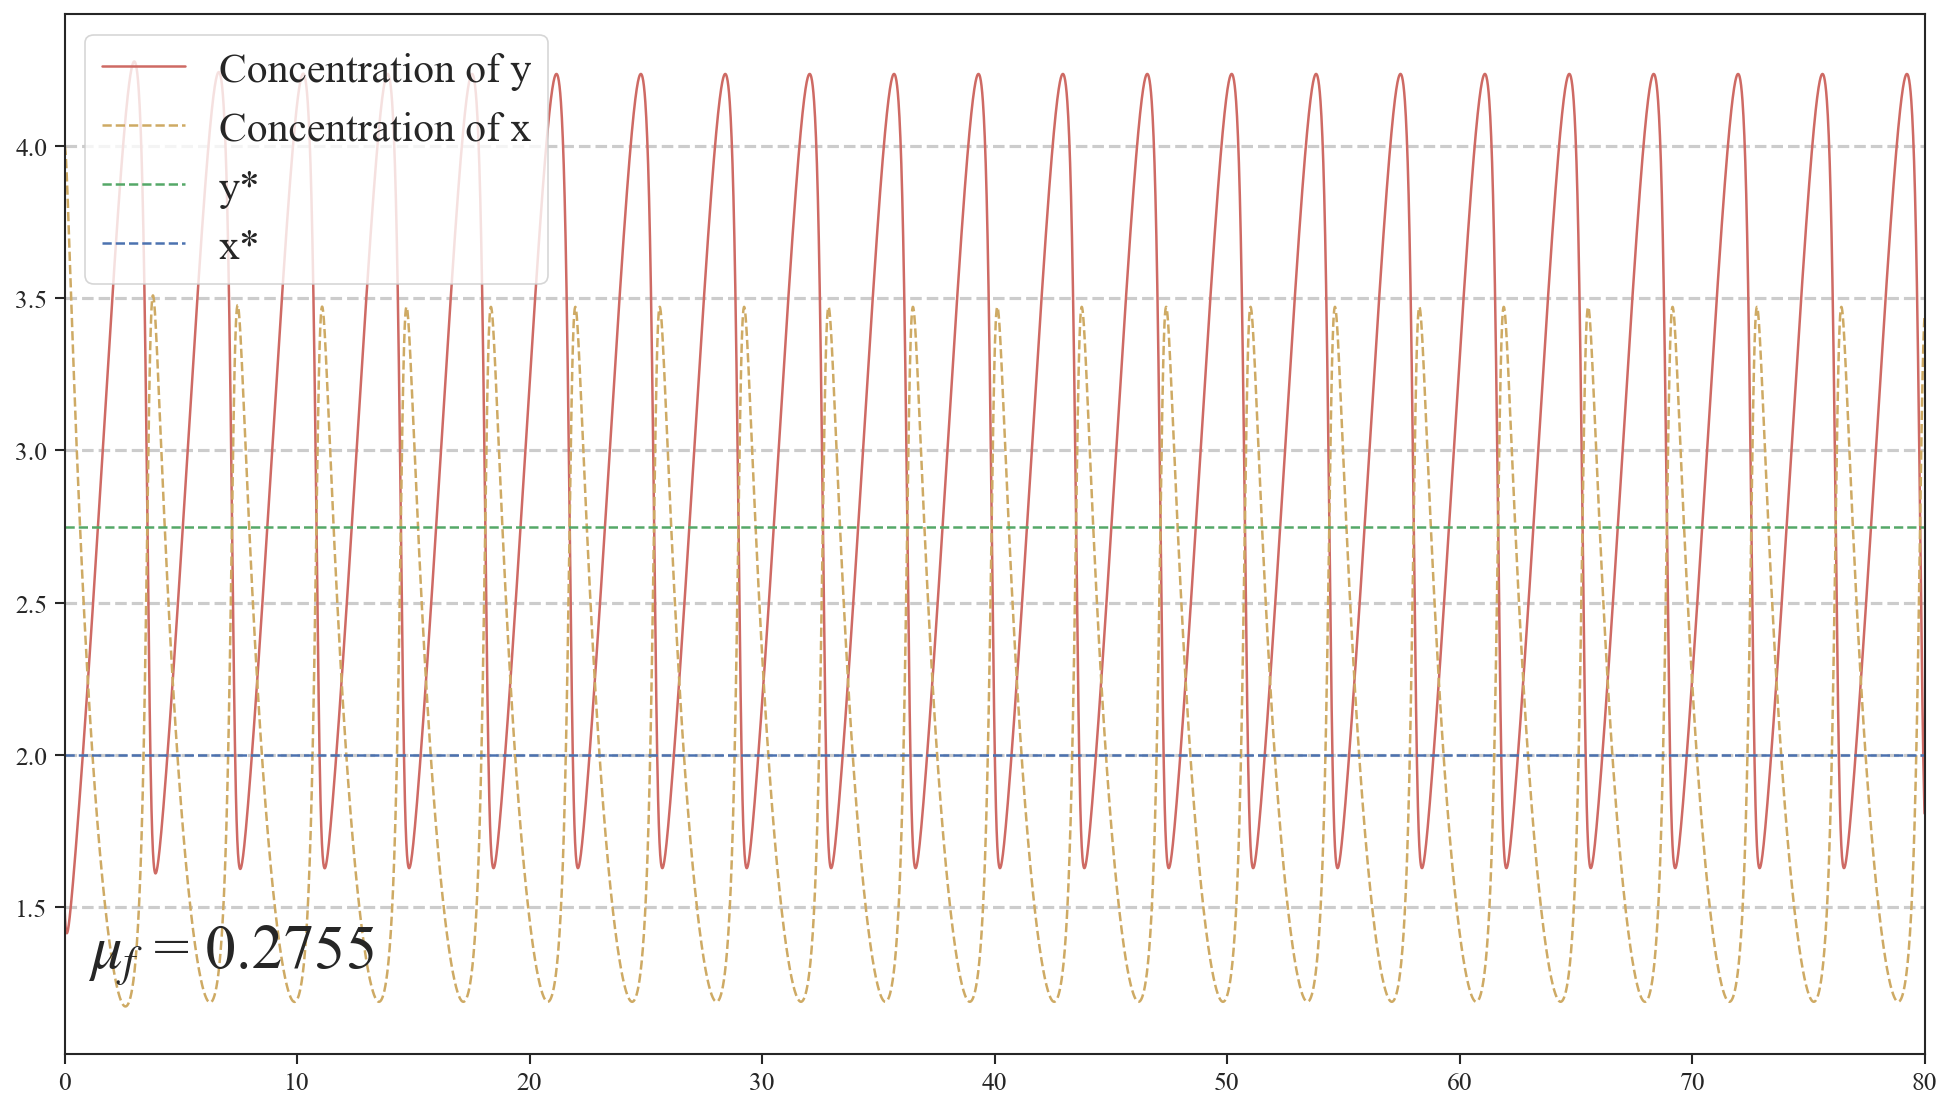

In [6]:

fig, ax = plt.subplots()

ax.plot(t_list, y_list, label='Concentration of y')
ax.plot(t_list, x_list, label='Concentration of x', ls='--')
# ax.plot(ty_peaks, y_peaks, 'ro', label='peaks')
ax.axhline(y_star, color='g', linestyle='--', label='y*')
ax.axhline(x_star, color='b', linestyle='--', label='x*')
ax.text(1, 1.3, f'$\mu_f$ = {y_mean_freq:.4f}', fontsize=30);
ax.set_xlim(0, 80)
ax.legend(fontsize=20);

(1.0, 4.0)

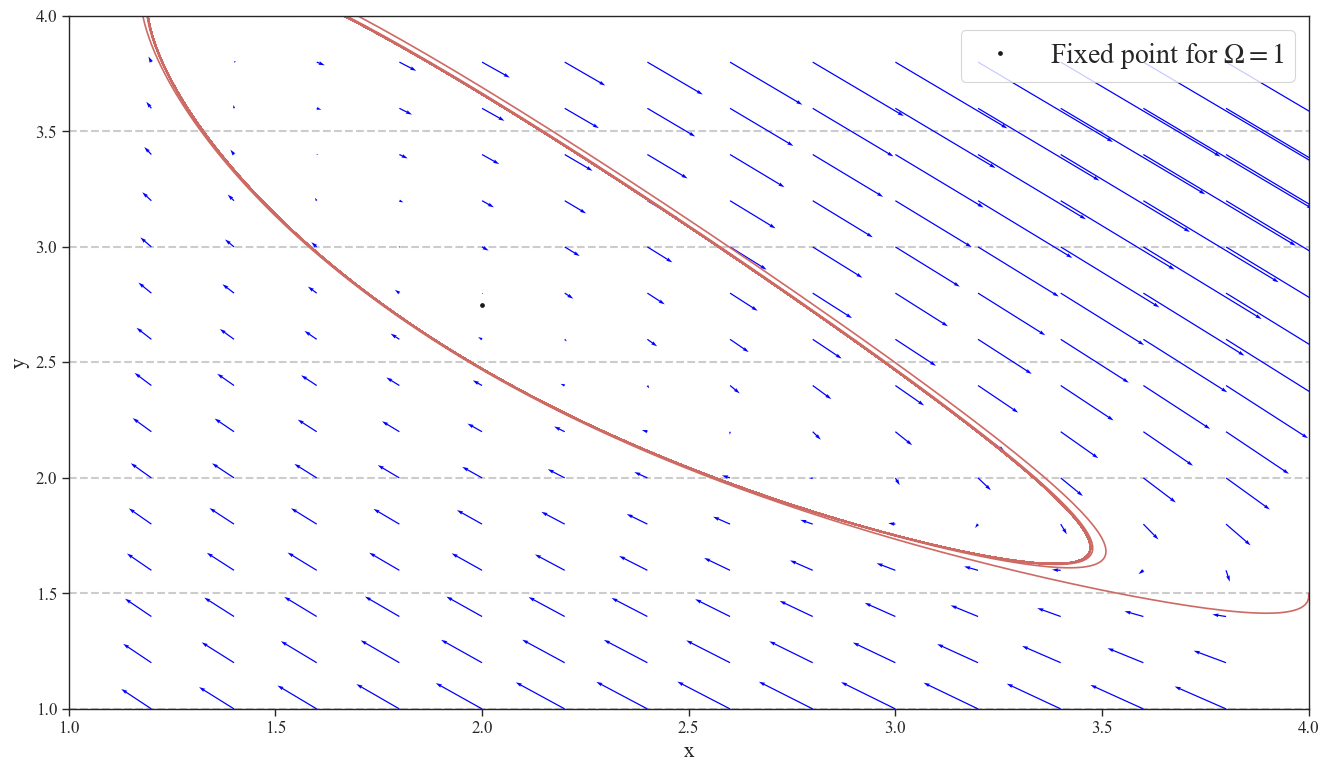

In [7]:
# 2D plot
fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(x_list, y_list)
plt.plot(x_star, y_star, 'k.', label=f'Fixed point for $\Omega = {V}$')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)


# Vector field
field_size = np.arange(1, 4, 0.2) * V
X, Y = np.meshgrid(field_size, field_size)
U = x_dot_init(X, Y, V, params)
P = y_dot_init(X, Y, V, params)


plt.quiver(X, Y, U, P, angles='xy', width=0.001, color='blue');

plt.xlim(1,4)
plt.ylim(1,4)


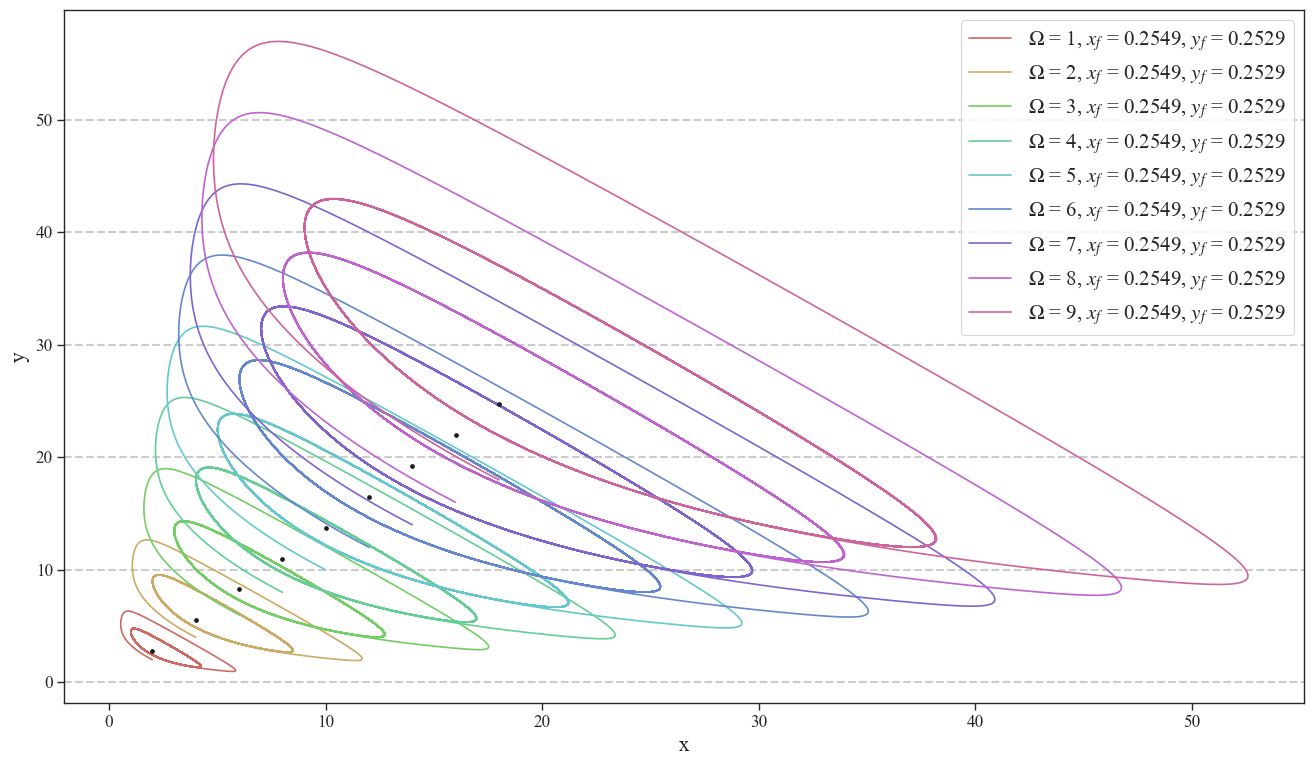

In [8]:
omega = np.arange(1, 10, 1)
var_change = np.array([2, 2])
x_mark_list = []
y_mark_list = []
x_freq_list = []
y_freq_list = []
dt_new = 0.001
t_max_new = 100

plt.figure(figsize=(16,9), dpi=100)
for i in omega:
    x_list_sim, y_list_sim, t_list_sim = euler(var_change, i, dt_new, t_max_new, params)
    x_mark_list.append(x_mark(i, params))
    y_mark_list.append(y_mark(i, params))
    x_freq = freq_find(x_list_sim, t_list_sim)
    y_freq = freq_find(y_list_sim, t_list_sim)
    plt.plot(x_list_sim, y_list_sim, label=f'$\Omega$ = {i}, $x_f$ = {x_freq:.4f}, $y_f$ = {y_freq:.4f}')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=15)

plt.plot(x_mark_list, y_mark_list, 'k.', label='Stable fixed point')

____

# Adding oscillatory term $ A cos(\omega t)$

In [9]:

@numba.njit
def x_dot(x, y, t, a, b, c, d, V, omega, A):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y + A * np.cos(omega * t)
    return dxdt

@numba.njit
def y_dot(x, y, V, b, c):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt

a = 2
b = 4.5
c = 1
d = 1
V = 100

@numba.njit
def euler(var_change, V, omega, A, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, t, a, b, c, d, V, omega, A)
        y += dt * y_dot(x, y, V, b, c)
        t += dt
    return x_list, y_list, t_list

@numba.njit
def amplitude_find(list1, list2, t_list, t_choise = 30):
    t_list = np.array(t_list)
    list1 = np.array(list1)
    list2 = np.array(list2)
    
    mask = np.where(t_list > t_choise)
    list1_mask = list1[mask[0]]
    list2_mask = list2[mask[0]]

    return np.max(list1_mask) - np.min(list1_mask), np.max(list2_mask) - np.min(list2_mask)



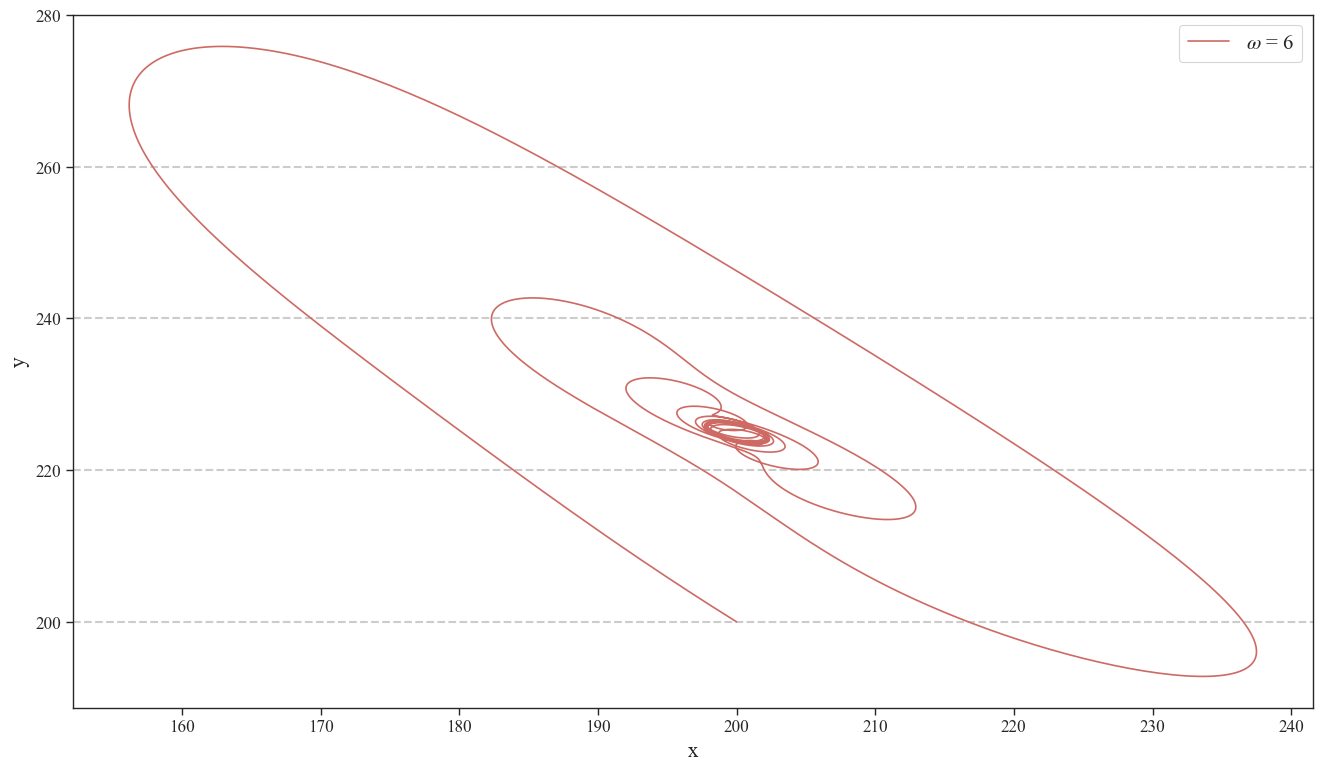

In [10]:
# run euler simulaiton with new x_dot and y_dot functions

omega = np.array([6])
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig, ax = plt.subplots(figsize=(16,9), dpi=100)

for i in omega:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    ax.plot(x_list, y_list, label=f'$\omega$ = {i}')

ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.legend(fontsize=15)




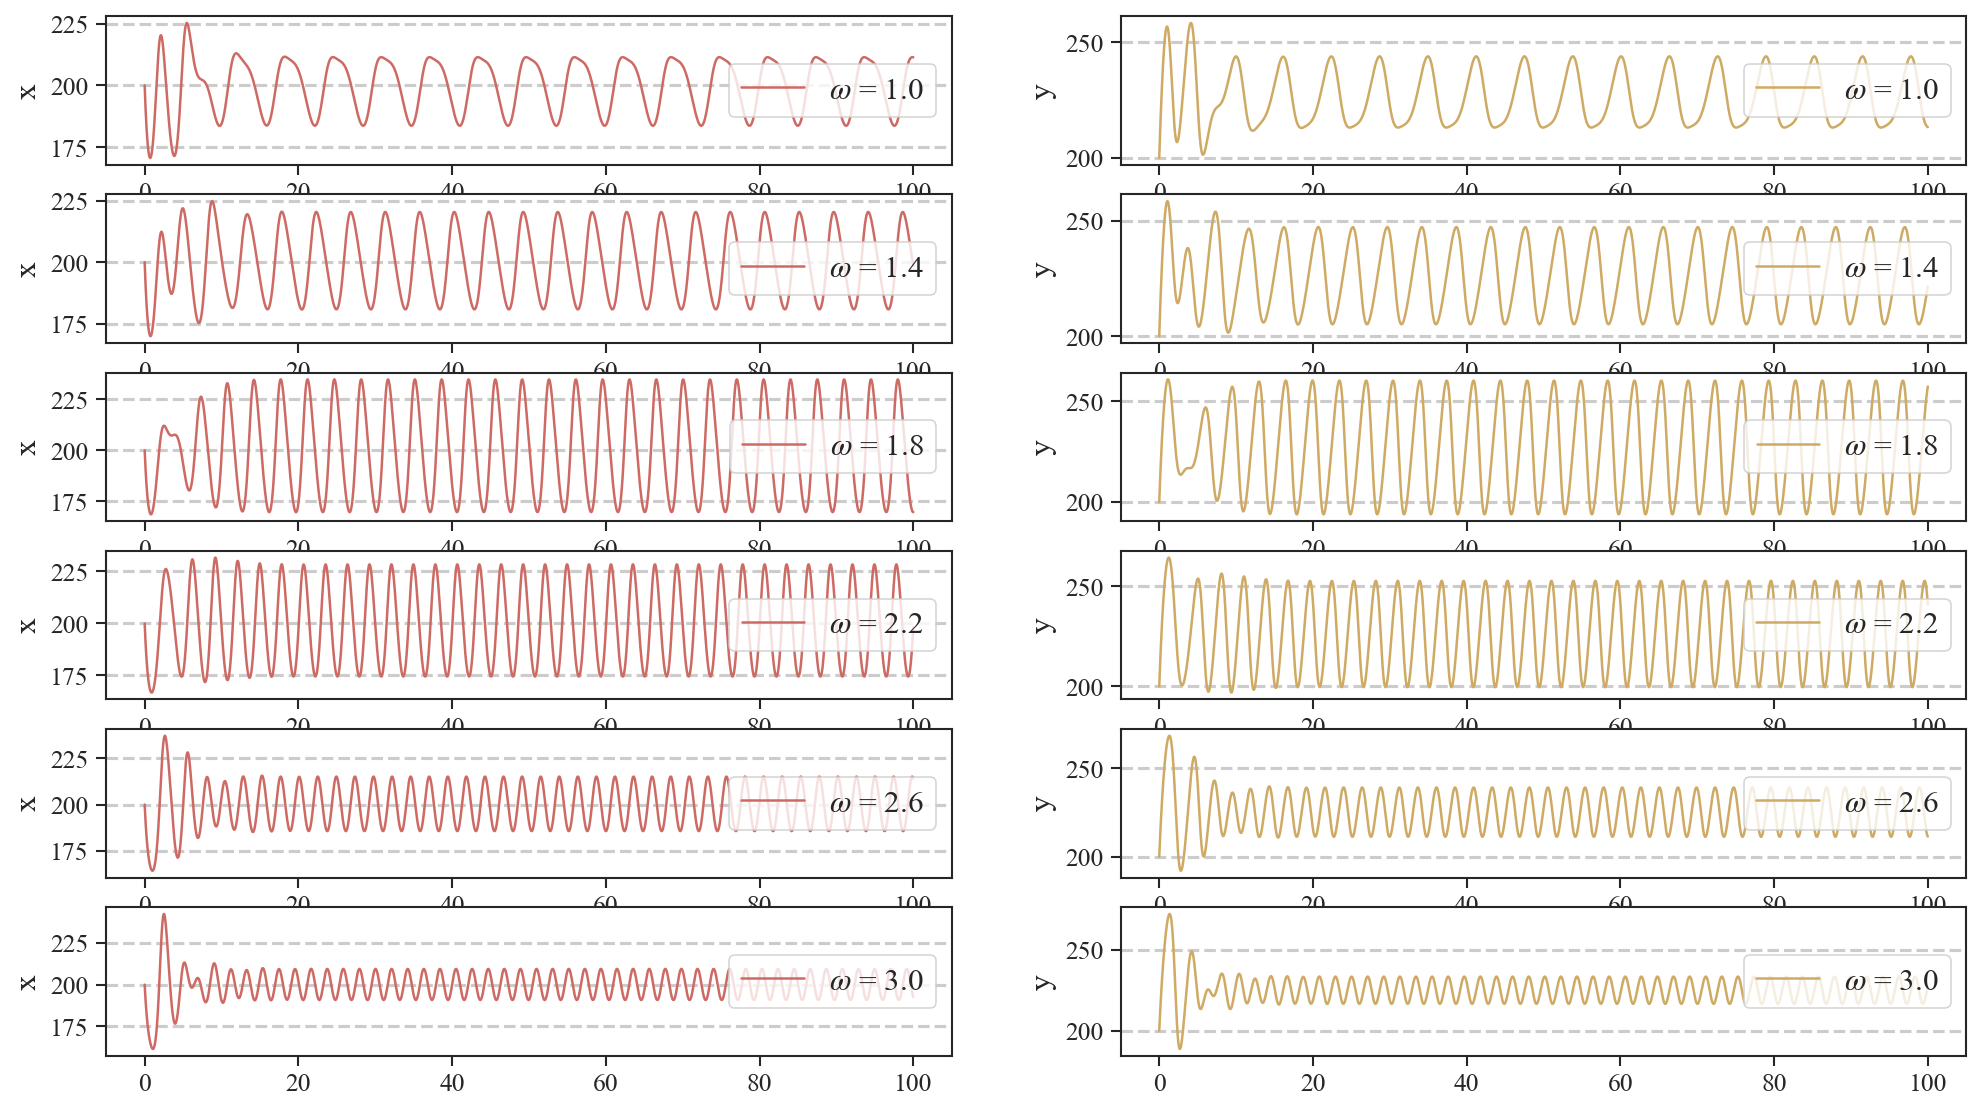

In [11]:
# plot x(t) and y(t) for different omega values

omega = np.linspace(1, 3, 6)
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig_rows = len(omega)
fig, ax = plt.subplots(fig_rows, 2)


amp_x = []
amp_y = []

for i, j in enumerate(omega):
    x_list, y_list, t_list = euler(var_change, V, j, A, dt, t_max)
    

    ax[i, 0].plot(t_list, x_list, label=f'$\omega$ = {j}')
    ax[i, 1].plot(t_list, y_list, label=f'$\omega$ = {j}', color = colors[1])
    ax[i, 0].set_ylabel('x', fontsize=15)
    ax[i, 1].set_ylabel('y', fontsize=15)
    ax[i, 0].legend(fontsize=15, loc='center right')
    ax[i, 1].legend(fontsize=15, loc='center right')



### For a large number of $\omega$ 

In [12]:
omega_list = np.linspace(0.1, 5, 100)    
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

amp_x = []
amp_y = []

for i in omega_list:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    x_max, y_max = amplitude_find(x_list, y_list, t_list, t_choise=30)
    amp_x.append(x_max)
    amp_y.append(y_max)


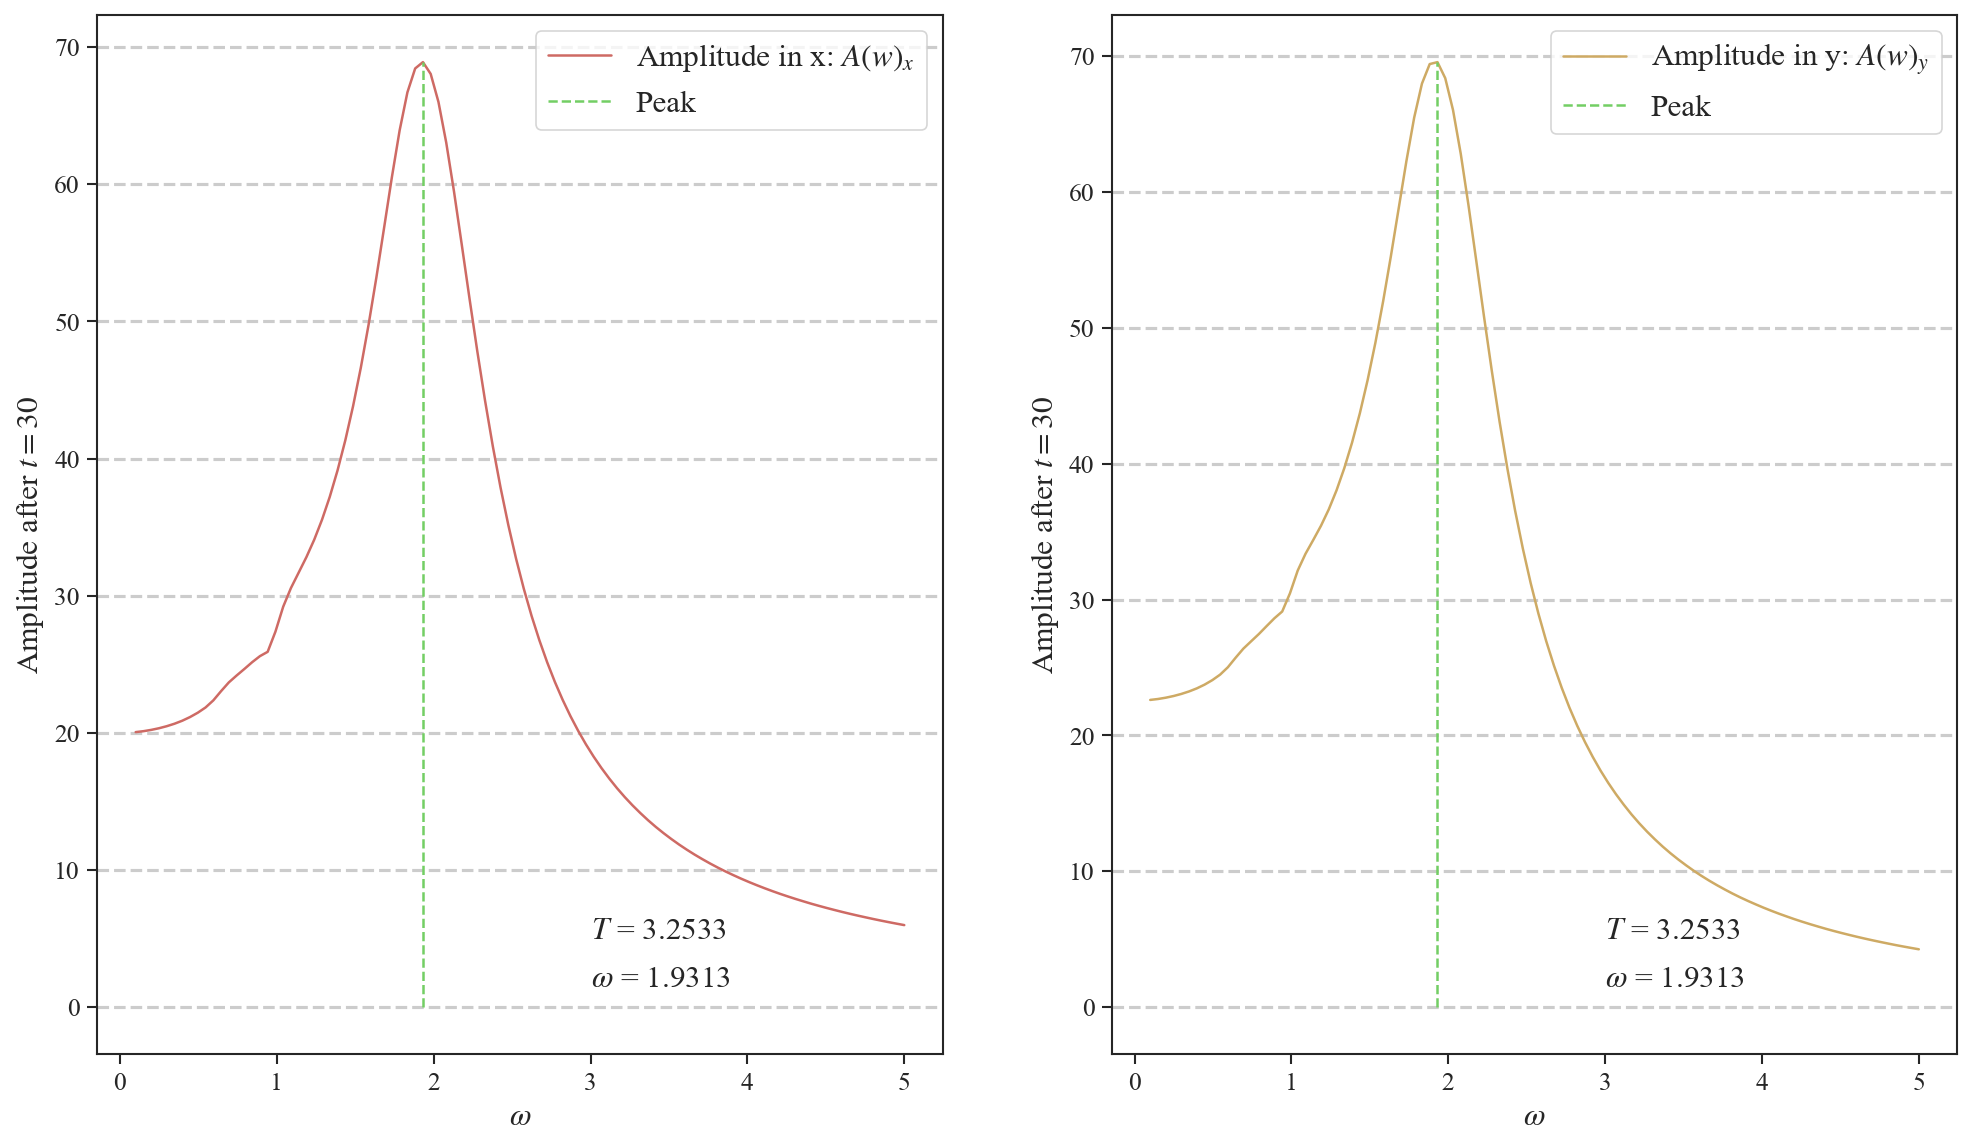

In [13]:
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()

# find peak

x_peak = np.max(amp_x)
y_peak = np.max(amp_y)
omega_x_peak = omega_list[np.argmax(amp_x)]
omega_y_peak = omega_list[np.argmax(amp_y)]
T_x = 2*np.pi/omega_x_peak
T_y = 2*np.pi/omega_y_peak

ax[0].plot(omega_list, amp_x, label=r'Amplitude in x: $A(w)_x$')
ax[0].set_xlabel('$\omega$', fontsize=15)
ax[0].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[0].vlines(omega_x_peak, 0, x_peak, color= colors[2], linestyle='--', label='Peak')
ax[0].text(3, 1.5, fr'$\omega$ = {omega_x_peak:.4f}', fontsize=15);
ax[0].text(3, 5, f'$T$ = {T_x:.4f}', fontsize=15);
ax[0].legend(fontsize=15)

ax[1].plot(omega_list, amp_y, label=r'Amplitude in y: $A(w)_y$', color = colors[1])
ax[1].set_xlabel('$\omega$', fontsize=15)
ax[1].vlines(omega_y_peak, 0, y_peak, color=colors[2], linestyle='--', label='Peak')
ax[1].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[1].text(3, 1.5, fr'$\omega$ = {omega_y_peak:.4f}', fontsize=15);
ax[1].text(3, 5, f'$T$ = {T_y:.4f}', fontsize=15);
ax[1].legend(fontsize=15)


____